In [2]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
%pip install yahoo_fin --upgrade
import yahoo_fin
import numpy as np
from yahoo_fin.stock_info import get_data
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib as mpl

Note: you may need to restart the kernel to use updated packages.


In [40]:
import yfinance as yf
stock_ticker = "AMZN"

stock = yf.Ticker(stock_ticker)
industry = stock.info['industry']
sector = stock.info['sector']

print(f"Ticker Symbol: {stock_ticker}")
print(f"Industry: {industry}")
print(f"Sector: {sector}")

Ticker Symbol: AMZN
Industry: Internet Retail
Sector: Consumer Cyclical


In [41]:
#PULL DATA AND ENGINEERED FEATURES USING YAHOO FINANCE API
stock_data = get_data(stock_ticker, start_date="01/01/2010", end_date="12/31/2019", index_as_date=True, interval="1d")

#log returns
stock_data['Log_Return'] = np.log(stock_data['close'] / stock_data['close'].shift(1))

# 20 and 50 day moving day averages
stock_data['SMA_20'] = stock_data['close'].rolling(window=20).mean()
stock_data['SMA_50'] = stock_data['close'].rolling(window=50).mean()

#exponential moving average/EMA
stock_data['EMA_20'] = stock_data['close'].ewm(span=20, adjust=False).mean()

#relative strength index/RSI
window_length = 14
delta = stock_data['close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
ema_up = up.ewm(com=window_length - 1, adjust=True, min_periods=window_length).mean()
ema_down = down.ewm(com=window_length - 1, adjust=True, min_periods=window_length).mean()
rs = ema_up / ema_down
stock_data['RSI'] = 100 - (100 / (1 + rs))

#technical indicators
stock_data['MACD'] = stock_data['close'].ewm(span=12).mean() - stock_data['close'].ewm(span=26).mean()
stock_data['MACD_Signal'] = stock_data['MACD'].ewm(span=9).mean()
stock_data['Stochastic_%K'] = stock_data['close'].rolling(window=14).apply(lambda x: (x[-1] - x.min()) / (x.max() - x.min()), raw=True)
stock_data['Stochastic_%D'] = stock_data['Stochastic_%K'].rolling(window=3).mean()

#volume indicators
stock_data['Volume_SMA_20'] = stock_data['volume'].rolling(window=20).mean()
stock_data['Volume_Ratio'] = stock_data['volume'] / stock_data['Volume_SMA_20']

#volatility indicators
stock_data['Daily_Return_Volatility'] = stock_data['Log_Return'].rolling(window=14).std() * np.sqrt(252)
stock_data['Garman_Klass_Volatility'] = np.sqrt(252 * 0.5 * ((np.log(stock_data['close'] / stock_data['close'].shift(1)))**2).rolling(window=14).mean())

#momentum and trend indicators
stock_data['Price_Momentum'] = stock_data['close'].pct_change(periods=14)
stock_data['Rate_of_Change'] = stock_data['close'].pct_change(periods=9)
stock_data['Trend'] = np.where(stock_data['close'] > stock_data['close'].shift(1), 1, -1)

# seasonality indicators
stock_data['Day_of_Week'] = stock_data.index.dayofweek
stock_data['Month'] = stock_data.index.month

# information ratio
stock_data['info_ratio'] = stock_data['close'] / stock_data['close'].shift(14) / stock_data['Daily_Return_Volatility']

stock_data['close_change'] = stock_data['close'] - stock_data['close'].shift(1)
stock_data['range'] = stock_data['high'] - stock_data['low']
stock_data['ATR'] = stock_data['range'].rolling(window=14).mean()
stock_data['stoc_oscillator'] = (stock_data['close'] - stock_data['low'].rolling(window=14).min()) / (stock_data['high'].rolling(window=14).max() - stock_data['low'].rolling(window=14).min())

stock_data['cum_ret'] = stock_data['close'] / stock_data.iloc[-1]['open']

#data head
stock_data = stock_data.sort_index(ascending=False).dropna().iloc[::-1]
print(stock_data.head(100))

              open    high     low   close  adjclose     volume ticker  \
2010-03-16  6.5620  6.6145  6.5250  6.5895    6.5895   82650000   AMZN   
2010-03-17  6.6205  6.6345  6.5610  6.5670    6.5670   87176000   AMZN   
2010-03-18  6.5510  6.6425  6.5220  6.6380    6.6380  100426000   AMZN   
2010-03-19  6.6855  6.6855  6.4830  6.5175    6.5175  178100000   AMZN   
2010-03-22  6.5100  6.5480  6.4320  6.5235    6.5235  107668000   AMZN   
...            ...     ...     ...     ...       ...        ...    ...   
2010-07-30  5.7765  5.9370  5.7255  5.8945    5.8945  141550000   AMZN   
2010-08-02  5.9575  6.0190  5.8785  6.0035    6.0035  108874000   AMZN   
2010-08-03  6.0000  6.1435  5.9840  6.1210    6.1210  119076000   AMZN   
2010-08-04  6.1530  6.4235  6.1500  6.3790    6.3790  185416000   AMZN   
2010-08-05  6.3385  6.4000  6.2910  6.3915    6.3915   85646000   AMZN   

            Log_Return    SMA_20   SMA_50  ...  Rate_of_Change  Trend  \
2010-03-16    0.005021  6.236600  6.21

In [42]:
# from sklearn.preprocessing import MinMaxScaler
# #preprocess data
# stock_data = stock_data.drop(columns=['ticker'])
# scaler = MinMaxScaler(feature_range=(-1, 1)).set_output(transform="pandas")
# stock_data_time = scaler.fit_transform(stock_data)
# scaler = MinMaxScaler(feature_range=(-1, 1)).set_output(transform="pandas")
# scaler.fit(stock_data[['close']])
# stock_data_time = stock_data_time.dropna()

# print(stock_data_time.info())

from sklearn.preprocessing import MinMaxScaler

# preprocess data
stock_data = stock_data.drop(columns=['ticker'])

# create a scaler for all data
scaler_all = MinMaxScaler(feature_range=(-1, 1))
stock_data_scaled = scaler_all.fit_transform(stock_data)

# inverse transform and multiply by 100
stock_data_inverse = scaler_all.inverse_transform(stock_data_scaled)

# create a separate scaler for the 'close' column
scaler_close = MinMaxScaler(feature_range=(-1, 1))
scaler_close.fit(stock_data[['close']])

# inverse transform 'close' column and multiply by 100
close_inverse = scaler_close.inverse_transform(stock_data[['close']])

# convert numpy array to DataFrame
stock_data_inverse_df = pd.DataFrame(stock_data_inverse, columns=stock_data.columns)

# drop NA values
stock_data_inverse_df = stock_data_inverse_df.dropna()

print(stock_data_inverse_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   open                     2466 non-null   float64
 1   high                     2466 non-null   float64
 2   low                      2466 non-null   float64
 3   close                    2466 non-null   float64
 4   adjclose                 2466 non-null   float64
 5   volume                   2466 non-null   float64
 6   Log_Return               2466 non-null   float64
 7   SMA_20                   2466 non-null   float64
 8   SMA_50                   2466 non-null   float64
 9   EMA_20                   2466 non-null   float64
 10  RSI                      2466 non-null   float64
 11  MACD                     2466 non-null   float64
 12  MACD_Signal              2466 non-null   float64
 13  Stochastic_%K            2466 non-null   float64
 14  Stochastic_%D           

In [43]:
stock_data_inverse_df.head(10)

,open,high,low,close,adjclose,volume,Log_Return,SMA_20,SMA_50,EMA_20,...,Rate_of_Change,Trend,Day_of_Week,Month,info_ratio,close_change,range,ATR,stoc_oscillator,cum_ret
0,6.5620,6.6145,6.5250,6.5895,6.5895,82650000.0,0.005021,6.236600,6.21460,6.342075,...,0.046866,1.0,1.0,3.0,4.111622,0.0330,0.0895,0.153143,0.868665,0.070326
1,6.6205,6.6345,6.5610,6.5670,6.5670,87176000.0,-0.003420,6.274175,6.21204,6.363496,...,0.021863,-1.0,2.0,3.0,4.320867,-0.0225,0.0735,0.149500,0.833721,0.070085
2,6.5510,6.6425,6.5220,6.6380,6.6380,100426000.0,0.010754,6.310875,6.21011,6.389639,...,0.029866,1.0,3.0,3.0,4.379220,0.0710,0.1205,0.149429,0.913617,0.070843
3,6.6855,6.6855,6.4830,6.5175,6.5175,178100000.0,-0.018320,6.342950,6.20821,6.401816,...,0.001845,-1.0,4.0,3.0,5.384695,-0.1205,0.2025,0.138429,0.605936,0.069557
4,6.5100,6.5480,6.4320,6.5235,6.5235,107668000.0,0.000920,6.374100,6.20868,6.413405,...,0.012809,1.0,0.0,3.0,5.374463,0.0060,0.1160,0.137607,0.618219,0.069621
5,6.5445,6.5470,6.4035,6.4630,6.4630,84262000.0,-0.009317,6.404150,6.20442,6.418129,...,-0.009578,-1.0,1.0,3.0,5.132619,-0.0605,0.1435,0.138893,0.427578,0.068975
6,6.4320,6.4700,6.3600,6.4020,6.4020,93928000.0,-0.009483,6.424950,6.20215,6.416593,...,-0.041473,-1.0,2.0,3.0,5.374278,-0.0610,0.1100,0.135036,0.136045,0.068324
7,6.4570,6.8455,6.4020,6.7365,6.7365,324192000.0,0.050930,6.466275,6.20953,6.447060,...,0.022076,1.0,3.0,3.0,3.654461,0.3345,0.4435,0.158214,0.775489,0.071894
8,6.7450,6.8495,6.6880,6.7530,6.7530,131314000.0,0.002446,6.507925,6.21548,6.476197,...,0.029970,1.0,4.0,3.0,3.647028,0.0165,0.1615,0.158536,0.802859,0.072070
9,6.7685,6.8315,6.7165,6.7560,6.7560,92538000.0,0.000444,6.534375,6.22325,6.502845,...,0.025267,1.0,0.0,3.0,3.758917,0.0030,0.1150,0.156607,0.808989,0.072102


In [34]:
from sklearn.model_selection import train_test_split

# Set the seed
np.random.seed(42)

# Set the test size
test_size = 0.2

# Split the data
train, test = train_test_split(stock_data_inverse_df['close'], test_size=test_size, random_state=42)

In [35]:
train

463      8.921000
1037    15.019000
1114    16.726500
1503    28.757000
1818    50.567001
          ...    
1638    38.484501
1095    18.042000
1130    16.566500
1294    20.955000
860     14.567000
Name: close, Length: 1972, dtype: float64

Train RMSE: 0.025
predicted=63.862851, expected=65.260002
predicted=65.302194, expected=65.242996
predicted=65.193731, expected=64.750000
predicted=64.685934, expected=64.666000
predicted=64.669290, expected=64.728996
predicted=64.748084, expected=66.365501
predicted=66.432204, expected=68.126999
predicted=68.187886, expected=67.875504
predicted=67.783070, expected=68.897499
predicted=68.894212, expected=70.102501
predicted=70.156813, expected=70.884003
predicted=70.890284, expected=71.890999
predicted=71.915795, expected=72.544502
predicted=72.562255, expected=69.500000
predicted=69.315857, expected=71.497498
predicted=71.568357, expected=69.500000
predicted=69.557009, expected=72.141998
predicted=72.011248, expected=70.838997
predicted=71.033942, expected=67.525002
predicted=67.397188, expected=66.980003
predicted=66.990370, expected=69.311501
predicted=69.486133, expected=70.725502
predicted=70.750593, expected=72.552498
predicted=72.457429, expected=73.087997
predicted=73.026622, e

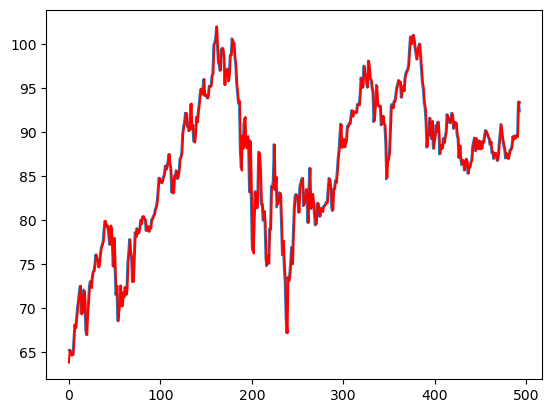

In [44]:
import warnings
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the order of the ARIMA model
order = (3,1,0)

test_size = 0.2
split_point = int(len(stock_data_inverse_df) * (1 - test_size)) 
train, test = stock_data_inverse_df['close'][0:split_point], stock_data_inverse_df['close'][split_point:]

history = [x for x in train]
predictions = list()

# walk-forward validation for training data
train_predictions = []
last_successful_prediction = None
for t in range(len(train)):
    try:
        model = ARIMA(history[:t+1], order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        train_predictions.append(yhat)
        last_successful_prediction = yhat
    except:
        if last_successful_prediction is not None:
            train_predictions.append(last_successful_prediction)
        else:
            train_predictions.append(train.iloc[t-1] if t > 0 else train.iloc[t])

# calculate training RMSE
train_rmse = sqrt(mean_squared_error(train, train_predictions))
print('Train RMSE: %.3f' % train_rmse)

# walk-forward validation for test data
for t in range(len(test)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test.iloc[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# calculate test RMSE
test_rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % test_rmse)

# plot forecasts against actual outcomes
plt.plot(range(len(test)), test.values)
plt.plot(range(len(predictions)), predictions, color='red')
plt.show()

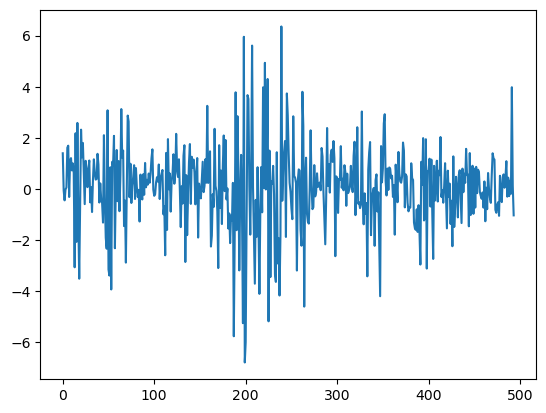

In [45]:
residuals = [test.iloc[i]-predictions[i] for i in range(len(test))]
plt.plot(residuals)
plt.show()